In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import snscrape.modules.twitter as sntwitter
from emoji import UNICODE_EMOJI # Read documentation
import requests
import bs4
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt

**Defining example ticker to work with**

In [3]:
ticker = "AAPL"

**Twitter scraping example**

In [4]:
def twitter_scrape(ticker, max_tweets):
    all_tweets = []
    all_emojis = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(ticker).get_items()):
        if i > max_tweets:
            break
        all_tweets.append(tweet.content)

    for i in all_tweets:
        for element in i:
            if element in UNICODE_EMOJI['en']:
                all_emojis.append(element)

    return (all_emojis, all_tweets)

all_emojis = twitter_scrape(ticker, 100)[0]
all_tweets = twitter_scrape(ticker, 100)[1]

**Obtaining S&P 500 tickers:**

In [5]:
wikipedia=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = wikipedia[0]
tickers = first_table["Symbol"]
sp_tickers = [i for i in tickers]

**Scraping for emoji category data from the web:**

In [6]:
url = "http://kt.ijs.si/data/Emoji_sentiment_ranking/"
response = requests.get(url)
html_parsed = bs4.BeautifulSoup(response.text, 'html.parser')


**Classifying the main table into sub-tables with individual emojis (TRs):**

In [7]:
tables = html_parsed.find_all("tr")

**Scraping emoji symbols:**

In [8]:
emoji_list = []

for row in tables:
    string_row = str(row)
    emoji = string_row[(string_row.find("<tr><td>")+8):(string_row.find("<tr><td>")+9)]
    emoji_list.append(emoji)

**Scraping sentiment scores:**

In [9]:
sentiment_scores = []

for row in tables:
    string_row = str(row)
    if string_row[string_row.find("sentiment score: ")+17] == "-":
        score = string_row[(string_row.find("sentiment score: ")+17):(string_row.find("sentiment score: ")+23)]
    else:
        score = string_row[(string_row.find("sentiment score: ")+17):(string_row.find("sentiment score: ")+22)]
    sentiment_scores.append(score)

**Creating a dictionary:**

In [10]:
score_dict = {}
for i in range(1,752):
    score_dict[emoji_list[i]] = sentiment_scores[i]

**Calculating sentiment scores from actual tweets:**

In [11]:
def emoji_score(all_emojis):
    total_score = 0
    for emoji in all_emojis:
        if emoji in score_dict.keys():
            total_score = total_score + float(score_dict[emoji])
    return round(total_score,2)

emoji_score1 = emoji_score(all_emojis)
print("Current sentiment score for", ticker, "is", round(emoji_score1, 3))

Current sentiment score for AAPL is 20.11


**Starting with text analysis using NLTK:**

Source: https://realpython.com/python-nltk-sentiment-analysis/

**Importing stop-words, such as "and", "or" and "but" to filter them out:**

In [12]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Creating tokenized lists of tweet words:**

In [13]:
tokenized_list = []
for x in all_tweets:
    split_tweet = x.split()
    for word in split_tweet:
        if word.isalpha():
            if word.lower() not in stopwords:
                tokenized_list.append(word.lower())


**Looking at the most frequent words:**

In [14]:
x = nltk.FreqDist(tokenized_list)
x.tabulate(10)

  apple    公開記念      de opening  stocks   price tuesday   stock  iphone reports 
     17      12      10       7       7       6       6       6       6       6 


**Looking at the most frequent three-word collocations:**

In [15]:
y = nltk.collocations.TrigramCollocationFinder.from_words(tokenized_list)
y.ngram_fd.most_common(5)

[(('octane', 'predicting', 'gain'), 5),
 (('predicting', 'gain', 'opening'), 5),
 (('gain', 'opening', 'price'), 5),
 (('opening', 'price', 'tuesday'), 5),
 (('reports', 'today', 'markets'), 5)]

**Performing sentiment analysis using VADER library:**

In [16]:
sent = SentimentIntensityAnalyzer()

**Counting the number of positive, negative and neutral tweets:**

In [17]:
def text_score(all_tweets):
    positive = 0
    negative = 0
    neutral = 0
    for x in all_tweets:
        tweet_score = sent.polarity_scores(x)
        if tweet_score["compound"] >= 0.3:
            positive += 1
        elif tweet_score["compound"] > -0.3:
            neutral += 1
        else:
            negative += 1
    return [positive, neutral, negative]

**Providing a summary of the sentiment, that is, emoji score + number of positive/negative/neutral tweets:**

In [18]:
emoji_score2 = emoji_score(all_emojis)
text_score2 = text_score(all_tweets)

print(emoji_score2, text_score2)

20.11 [36, 56, 9]


**Providing a summary of these scores for selected tickers:**

Explain here.

In [40]:
selected_ticker_scores = pd.DataFrame()
input_ticker = ""
input_ticker_list = []

while input_ticker != "Stop":  
    input_ticker = str(input("Please enter some tickers or type 'Stop': "))
    if input_ticker != "Stop":
        input_ticker_list.append(input_ticker)

for ticker in input_ticker_list:
    data = twitter_scrape(ticker, 100)
    emojis = data[0]
    tweets = data[1]
    selected_ticker_scores.loc[ticker, "Emoji Score"] = emoji_score(emojis)
    selected_ticker_scores.loc[ticker, "Positive Tweets"] = text_score(tweets)[0]
    selected_ticker_scores.loc[ticker, "Neutral Tweets"] = text_score(tweets)[1]
    selected_ticker_scores.loc[ticker, "Negative Tweets"] = text_score(tweets)[2]

**Sorting by the highest Emoji Scores, as an example:**

In [41]:
selected_ticker_scores.sort_values(by=["Emoji Score"], ascending=False)

,Emoji Score,Positive Tweets,Neutral Tweets,Negative Tweets
GOGL,18.74,15.0,80.0,6.0
TSLA,9.22,34.0,57.0,10.0


**Plotting:**

Defining a function for plotting selected column:

In [70]:
def plot_function(column):
    y = np.array(selected_ticker_scores[column])
    x = selected_ticker_scores.index

    chart_title = column + " For Selected companies"

    plt.style.use('ggplot')
    plt.bar(x, y, color="green")
    plt.xlabel("Companies")
    plt.ylabel(column)
    plt.title(chart_title)
    plt.show()

    plt.pie(y, labels=x)
    plt.title(chart_title)
    plt.show()

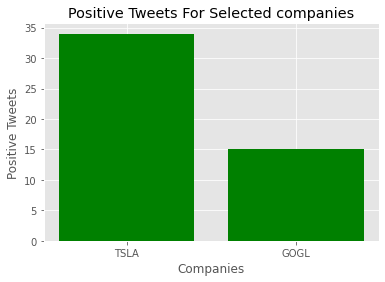

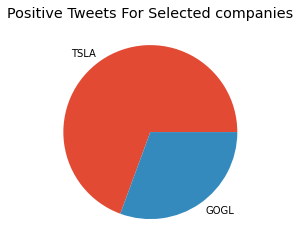

In [71]:
plot_function("Positive Tweets")